# Testing of the DETR code on the created DSAD directories on the HPC
Code taken from:
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

### First creating the dataset and dataloaders

In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    # Change to initialisation arguments. train argument removed and data_tag
    # argument added so that train, test and val datasets can be created
    def __init__(self, img_folder, processor, data_tag):
        """
        img_folder: path to the root directory with all images
        """
        # Change by adding error checking for data_tag
        if data_tag not in ['train', 'test', 'val']:
            raise ValueError("Incorrect data tag used for initialisation of dataset")
        root = os.path.dirname(img_folder)
        ann_file = os.path.join(root, 'annotations', f"{data_tag}_annotations.json") # Change to path for ann_file
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set up the CocoDetection class and image processor
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def get_img_folder_path(data_tag, device='HPC'):
    if device == 'HPC':
        img_folder = fr"..\DSAD4DeTr\{data_tag}\images"
    img_folder = fr"C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\{data_tag}\images"
    return img_folder

####################################
# Set data tag to train, test or val
####################################
test_img_folder = get_img_folder_path('test')
val_img_folder = get_img_folder_path('val')
train_img_folder = get_img_folder_path('train')

test_dataset = CocoDetection(img_folder=test_img_folder, processor=processor, data_tag='test')
val_dataset = CocoDetection(img_folder=val_img_folder, processor=processor, data_tag='val')
train_dataset = CocoDetection(img_folder=train_img_folder, processor=processor, data_tag='train')

loading annotations into memory...
Done (t=2.32s)
creating index...
index created!
loading annotations into memory...
Done (t=1.51s)
creating index...
index created!
loading annotations into memory...
Done (t=6.46s)
creating index...
index created!


In [3]:
# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 7889
Number of validation examples: 1978
Number of test examples: 3328


Verify an example by drawing boxes on it

Image n°1041026
{1: 'abdominal_wall',
 2: 'colon',
 3: 'inferior_mesenteric_artery',
 4: 'intestinal_veins',
 5: 'liver',
 6: 'pancreas',
 7: 'small_intestine',
 8: 'spleen',
 9: 'stomach',
 10: 'ureter',
 11: 'vesicular_glands'}


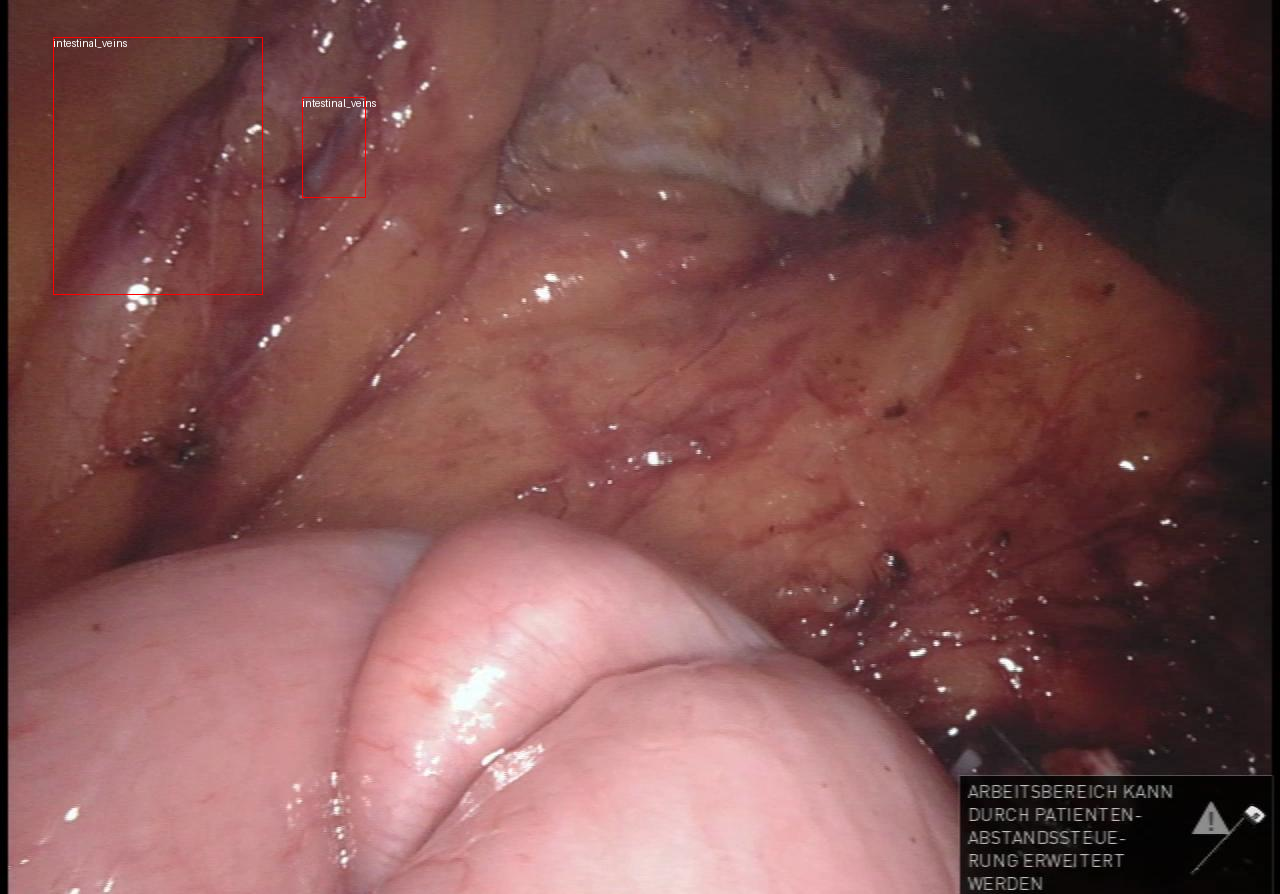

In [37]:
import numpy as np
import os
from PIL import Image, ImageDraw
from pprint import pprint

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(train_img_folder, image['file_name'])) # Change to parent path

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
pprint(id2label)

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Now creating the dataloaders

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [8]:
# Verification of the dataloader
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [13]:
pixel_values, target = train_dataset[0]
pixel_values.shape

torch.Size([3, 800, 1145])

In [14]:
print(target)

{'size': tensor([ 800, 1145]), 'image_id': tensor([1010400]), 'class_labels': tensor([1]), 'boxes': tensor([[0.5004, 0.1773, 0.9852, 0.3098]]), 'area': tensor([169010.3750]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 894, 1280])}


### Training the model using PyTorch Lightning

In [30]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
   def __init__(self, lr, lr_backbone, weight_decay):
      super().__init__()
      # replace COCO classification head with custom head
      # we specify the "no_timm" variant here to not rely on the timm library
      # for the convolutional backbone
      self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            num_labels=len(id2label),
                                                            ignore_mismatched_sizes=True)
      # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
      self.lr = lr
      self.lr_backbone = lr_backbone
      self.weight_decay = weight_decay

   def forward(self, pixel_values, pixel_mask):
      outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

      return outputs

   def common_step(self, batch, batch_idx):
      pixel_values = batch["pixel_values"]
      pixel_mask = batch["pixel_mask"]
      labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

      outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

      loss = outputs.loss
      loss_dict = outputs.loss_dict

      return loss, loss_dict

   def training_step(self, batch, batch_idx):
      loss, loss_dict = self.common_step(batch, batch_idx)
      # logs metrics for each training_step,
      # and the average across the epoch
      self.log("training_loss", loss)
      for k,v in loss_dict.items():
         self.log("train_" + k, v.item())

      return loss

   def validation_step(self, batch, batch_idx):
      loss, loss_dict = self.common_step(batch, batch_idx)
      self.log("validation_loss", loss)
      for k,v in loss_dict.items():
         self.log("validation_" + k, v.item())

      return loss

   def configure_optimizers(self):
      param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
               "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
               "lr": self.lr_backbone,
            },
      ]
      optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                 weight_decay=self.weight_decay)

      return optimizer

   def train_dataloader(self):
      return train_dataloader

   def val_dataloader(self):
      return val_dataloader

In [31]:
n_devices      = 1
epochs         = 20000 # Maximum value but will be prevented by early stopping
weight_decay   = 1e-4
learning_rate  = 1e-4
check_val_every_n_epoch = 5
load_from_checkpoint = False
checkpoint_path = None
last_manual_checkpoint = 1
last_epoch = 0
## LEARNING_SCHEDULER parameters for ReduceLROnPlateau from pytorch
factor          = 1e-1
lr_patience        = 10
stop_delta           = 1e-5
lr_monitored_var   = "Train_loss"
min_lr          = 1e-8
cooldown        = 5
### Parameters for FixedStep from pytorch
fix_step   = False
step_size  = 60
## STOP_CRITERIA parameters for EarlyStopping from pytorch_lightning
stop_monitored_var    = "Val_loss"
stop_delta            = 1e-5
mode             = "min"
stop_patience         = 10   ## Real_patient = patience * check_val_every_n_epoch
## Custom loss function
loss_tags = None
loss_components = []
loss_weights = []

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [32]:
# Define model and verify outputs
model = Detr(lr=learning_rate, lr_backbone=1e-5, weight_decay=weight_decay)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
outputs.logits.shape

torch.Size([4, 100, 12])

Start training. The early stopping criteria from train.py is used for this as this dataset is much larger than the one in the example.

In [36]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pathlib import Path
import os

# Results location
exp_path = Path('.\Results\DETRexample')
if not exp_path.exists():
    os.makedirs(exp_path)
print(exp_path)

checkpoint_path = exp_path / 'checkpoints'
if not checkpoint_path.exists():
    os.makedirs(checkpoint_path)
print(checkpoint_path)


Results\DETRexample
Results\DETRexample\checkpoints


In [ ]:

stop_criteria = EarlyStopping(monitor=stop_monitored_var, mode=mode, 
                    patience=stop_patience, min_delta=stop_delta, verbose=True)

# Change accelerator here to change from gpu to cpu running
trainer = Trainer(accelerator='gpu', devices=n_devices, 
            enable_progress_bar = True,
            max_epochs          = epochs,
            gradient_clip_val   = 0.1,
            callbacks           = [stop_criteria],
            check_val_every_n_epoch = check_val_every_n_epoch,
            default_root_dir    = exp_path)

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
                ckpt_path = checkpoint_path)

nets_path = exp_path / "nets"
if not (nets_path).exists():
    os.makedirs(nets_path)
torch.save(model.state_dict(), nets_path / 'final_model.pt')